In [ ]:
!pip install pandas matplotlib seaborn numpy scikit-learn imbalanced-learn yellowbrick mlxtend

In [2]:
# tools
import pandas as pd
# plot
import seaborn as sns
import matplotlib.pyplot as plt
# functions
from pathlib import Path
from sklearn.metrics import r2_score

## Carga de datos

In [3]:
dataset  = Path('../data/raw/installs.csv')
installs = (pd.read_csv(dataset, parse_dates=['created'])
              .assign(created = lambda df: (df.created.dt.floor('h')
                                                      .dt.tz_localize('UTC')
                                                      .dt.tz_convert('America/Montevideo')),
                      weekend = lambda df: df.created.dt.weekday.map(lambda wd: 1 if wd in [5,6] else 0)))

In [4]:
installs.columns

Index(['created', 'application_id', 'ref_type', 'ref_hash', 'click_hash',
       'attributed', 'implicit', 'device_countrycode', 'device_brand',
       'device_model', 'session_user_agent', 'user_agent', 'event_uuid',
       'kind', 'wifi', 'trans_id', 'ip_address', 'device_language', 'weekend'],
      dtype='object')

## Tamaño

In [17]:
installs.application_id.nunique()

31

In [11]:
installs.shape

(3412, 18)

In [18]:
3412 * 18

61416

In [23]:
installs.isna().sum()

created                  0
application_id           0
ref_type                 0
ref_hash                 0
click_hash            3412
attributed               0
implicit                 0
device_countrycode       0
device_brand          2365
device_model             1
session_user_agent      48
user_agent            1683
event_uuid            2547
kind                  2547
wifi                  1683
trans_id              3406
ip_address               0
device_language         34
dtype: int64

In [21]:
installs.isna().sum().sum() / (3412 * 18)

0.2886218574964179

In [86]:
installs.apply(lambda x: x.nunique())

created                212
application_id          31
ref_type                 2
ref_hash              3008
click_hash               0
attributed               1
implicit                 2
device_countrycode       2
device_brand            27
device_model           415
session_user_agent      12
user_agent             334
event_uuid             865
kind                    20
wifi                     2
trans_id                 4
ip_address            2717
device_language         30
weekend                  2
dtype: int64

## Created

In [46]:
installs.created.describe()

count                          3412
unique                          212
top       2019-03-12 10:00:00-03:00
freq                             35
first     2019-03-04 21:00:00-03:00
last      2019-03-13 20:00:00-03:00
Name: created, dtype: object

In [47]:
installs.columns

Index(['created', 'application_id', 'ref_type', 'ref_hash', 'click_hash',
       'attributed', 'implicit', 'device_countrycode', 'device_brand',
       'device_model', 'session_user_agent', 'user_agent', 'event_uuid',
       'kind', 'wifi', 'trans_id', 'ip_address', 'device_language', 'weekend'],
      dtype='object')

In [50]:
installs.groupby('created').size().max()

35

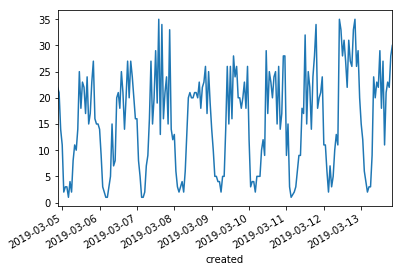

In [53]:
installs.groupby('created').size().plot()

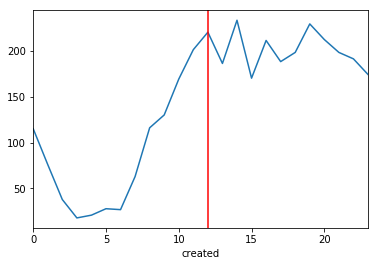

In [57]:
installs.groupby(installs.created.dt.hour).size().plot()
plt.axvline(12, 0, 100, color='red')

In [62]:
wewd = (installs.groupby(['weekend', installs.created.dt.hour]).size()
                .to_frame('installs')
                .reset_index())

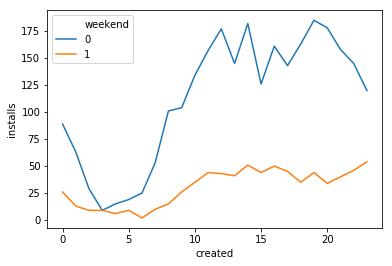

In [65]:
sns.lineplot('created', 'installs', hue='weekend', data=wewd)

In [25]:
installs.ref_hash.nunique()

3008

In [28]:
installs.ref_hash.value_counts().loc[lambda x: x > 1].shape

(379,)

In [33]:
installs.ref_hash.value_counts().value_counts() /

1    2629
2     356
3      21
4       2
Name: ref_hash, dtype: int64

In [34]:
2629 / 3008

0.8740026595744681

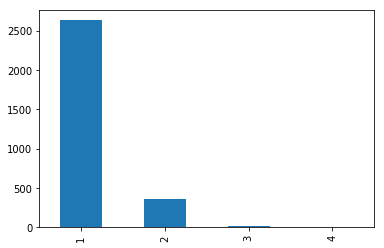

In [32]:
installs.ref_hash.value_counts().value_counts().plot(kind='bar')

In [81]:
installs.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language,weekend
0,2019-03-12 22:00:00-03:00,0,1891515180541284343,8464844987297247076,NaN,False,False,6333597102633388268,3.083059e+17,4.445252e+18,NaN,NaN,NaN,NaN,NaN,NaN,5529284367937637301,NaN,0
1,2019-03-13 01:00:00-03:00,0,1891515180541284343,3250564871270161533,NaN,False,False,6333597102633388268,3.083059e+17,4.445252e+18,NaN,NaN,NaN,NaN,NaN,NaN,6098022721363533304,NaN,0
2,2019-03-13 01:00:00-03:00,0,1891515180541284343,7953318831018100268,NaN,False,True,6333597102633388268,5.137992e+17,6.026543e+18,HasOffers Mobile AppTracking v1.0,NaN,0bfa9b4c-e07a-4522-b32d-138e3165ac98,Open,NaN,NaN,4636407223847323867,3.301378e+18,0
3,2019-03-13 01:00:00-03:00,0,1891515180541284343,7953318831018100268,NaN,False,False,6333597102633388268,5.137992e+17,6.026543e+18,NaN,NaN,NaN,NaN,NaN,NaN,4636407223847323867,NaN,0
4,2019-03-10 19:00:00-03:00,0,1891515180541284343,8355110941557237501,NaN,False,True,6333597102633388268,1.083369e+18,7.876612e+18,HasOffers Mobile AppTracking v1.0,NaN,8f235a8c-41bf-4399-b33d-c41577c949b0,Open,NaN,NaN,685400811232710215,3.301378e+18,1


## Varias instalaciones

In [147]:
users_features = ['ref_hash', 'ref_type', 'device_model', 'session_user_agent', 'device_language']
users = (installs.groupby(users_features)
                 .size()
                 .to_frame('instalaciones')
                 .reset_index())

In [148]:
users.shape

(2975, 6)

In [149]:
users.instalaciones.loc[lambda s: s > 1].shape

(360,)

In [151]:
360 / 2975

0.12100840336134454

In [152]:
users.head()

,ref_hash,ref_type,device_model,session_user_agent,device_language,instalaciones
0,4958526679100225,1891515180541284343,7.787531e+18,http-kit/2.0,9.028383e+18,1
1,5610335643679608,1891515180541284343,6.882415e+18,adjust.com,3.301378e+18,1
2,12589600065022004,1494519392962156891,2.928262e+18,adjust.com,3.301378e+18,1
3,13755514797422075,1891515180541284343,2.616228e+18,adjust.com,3.301378e+18,1
4,14817751128061288,1891515180541284343,6.882415e+18,adjust.com,3.301378e+18,1


In [153]:
from sklearn import preprocessing

In [154]:
le = preprocessing.LabelEncoder()

In [162]:
users_encoded = users.assign(ref_type = lambda df: le.fit_transform(df.ref_type),
                             device_model = lambda df: le.fit_transform(df.device_model),
                             session_user_agent = lambda df: le.fit_transform(df.session_user_agent),
                             device_language = lambda df: le.fit_transform(df.device_language),
                             outcome = lambda df: df.instalaciones.map(lambda x: 1 if x > 1 else 0))

In [164]:
from sklearn.linear_model import LogisticRegression

In [184]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [212]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [257]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [279]:
X_train, X_test, y_train, y_test = train_test_split(users_encoded.iloc[:, 1:5], users_encoded.iloc[:, 6]) 

In [259]:
rus = RandomOverSampler()

In [260]:
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [288]:
params = {
    'C': [0.01, 0.1, 1, 10, 20, 100],
    'class_weight': ['balanced', None],
    'penalty': ['l1', 'l2']
}

In [289]:
gs = GridSearchCV(lr, params, scoring='f1')

In [ ]:
gs.fit(X_train, y_train);

In [291]:
gs.best_params_

{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}

In [292]:
best = gs.best_estimator_

In [293]:
best.fit(X_train, y_train);

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [294]:
print(classification_report(y_test, best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.61      0.75       641
           1       0.27      0.92      0.42       103

   micro avg       0.65      0.65      0.65       744
   macro avg       0.63      0.76      0.58       744
weighted avg       0.88      0.65      0.70       744



In [295]:
roc_auc_score(y_test, best.predict(X_test))

0.7638171546279326

In [296]:
best.score(X_test, y_test)

0.6491935483870968

In [297]:
cf = confusion_matrix(y_test, best.predict(X_test))

In [254]:
from mlxtend.plotting import plot_confusion_matrix

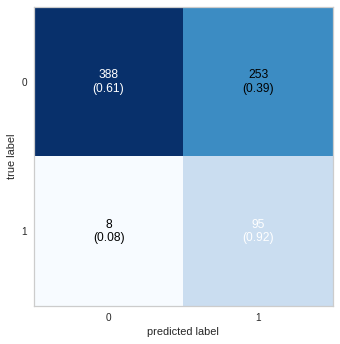

In [298]:
fig, ax = plot_confusion_matrix(conf_mat=cf, show_absolute=True, show_normed=True)
plt.show()